# Capstone V2 model

This is a GRU model with a pretrained glove.840B.300d word embedding layer.
The validation F1-score is 0.6417 at a threshold of 0.3.

In [1]:
# %load_ext memory_profiler

# Constants

In [2]:
MODEL_VERSION = 'capstoneV2'
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
MAX_WORDS = 50000

## Embedding helpers

In [3]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os

def loadEmbeddings(path, dimensions, mode='r', encoding=None, errors=None):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    f = open(path, buffering=((2<<16) + 8), mode=mode, encoding=encoding, errors=errors)
    for line in f:
        if len(line) <= 100:
            continue
        values = line.split()
        word = ''.join(values[:-dimensions])
        coefs = np.asarray(values[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [24]:
def getEmbeddingMatrix(embedding, word_index):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(MAX_WORDS, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

## Coverage helpers

In [4]:
from collections import Counter

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = Counter()
    for sentence in sentences:
        for word in sentence:
            vocab[word] += 1
    return vocab

In [5]:
import operator

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

# Import test/train dataset

In [6]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

## Split train/validation

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

## Fill data

In [8]:
X_train = train_df['question_text'].fillna('+++').tolist()
X_val = val_df['question_text'].fillna('+++').tolist()
X_test = test_df['question_text'].fillna('+++').tolist()

y_train = train_df['target']
y_val = val_df['target']

print('Found %s training questions.' % len(X_train))
print('Found %s validation questions.' % len(X_val))
print('Found %s test questions.' % len(X_test))

Found 1044897 training questions.
Found 261225 validation questions.
Found 56370 test questions.


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=' ', filters='',
                       char_level=False, oov_token=None, document_count=0,
                     )
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Shape of X_train: (1044897, 100)
Shape of y_train: (1044897,)
Found 392005 unique tokens.


## Build vocabulary with counts

In [15]:
%%time

train_vocab = build_vocab(train_df['question_text'])
del train_df
val_vocab = build_vocab(val_df['question_text'])
del val_df
test_vocab = build_vocab(test_df['question_text'])
del test_df

vocab = train_vocab + val_vocab + test_vocab
del train_vocab
del val_vocab
del test_vocab

CPU times: user 16.8 s, sys: 436 ms, total: 17.2 s
Wall time: 17.2 s


## Load embeddings, measure coverage and save embedding matrix

In [25]:
%%time

print('glove:')
glove_path = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index = loadEmbeddings(glove_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index

glove:
Loading embeddings from: ../input/embeddings/glove.840B.300d/glove.840B.300d.txt
Found 2195892 word vectors.
Found embeddings for 32.91% of vocab
Found embeddings for  88.16% of all text


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


CPU times: user 3min 10s, sys: 6.37 s, total: 3min 16s
Wall time: 3min 12s


## NN: Bidirectional GRU with pretrained embedding

In [26]:
%%time 

from keras.layers import Dense, Dropout, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional
from keras.layers import Activation, BatchNormalization, CuDNNGRU
from keras.layers import SpatialDropout1D, Concatenate, Flatten, Reshape
from keras.regularizers import l2
from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
x = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False) (inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(32)(x)
x = Activation("relu")(x)
x = Dropout(0.1)(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = Dropout(0.1)(x)
x = Dense(1)(x)
out = Activation("sigmoid")(x)

model = Model(inp, out)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [27]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [29]:
model.save(MODEL_VERSION + '.model.h5')
print("Saved model to disk")

Saved model to disk


# Setup f1-score, precision and recall metrics

In [30]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint(MODEL_VERSION + '.weights_checkpoint.h5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [31]:
%%time

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], epochs=2, batch_size=256)

Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 74s 71us/step - loss: 0.1278 - acc: 0.9518 - f1: 0.5137 - recall: 0.4430 - precision: 0.6582 - val_loss: 0.1130 - val_acc: 0.9558 - val_f1: 0.6060 - val_recall: 0.5811 - val_precision: 0.6536

Epoch 00001: val_f1 improved from -inf to 0.60598, saving model to capstoneV2.weights_checkpoint.h5
Epoch 2/2
1044897/1044897 [==============================] - 72s 69us/step - loss: 0.1123 - acc: 0.9562 - f1: 0.5893 - recall: 0.5289 - precision: 0.6975 - val_loss: 0.1100 - val_acc: 0.9568 - val_f1: 0.5530 - val_recall: 0.4603 - val_precision: 0.7280

Epoch 00002: val_f1 did not improve from 0.60598
CPU times: user 2min 49s, sys: 18.8 s, total: 3min 7s
Wall time: 2min 27s


# Predict validation labels

In [32]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

261225/261225 [==============================] - 3s 10us/step
CPU times: user 2.72 s, sys: 496 ms, total: 3.21 s
Wall time: 2.69 s


# Find optimal threshold

In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.5644, Recall score: 0.8484, Precision score: 0.4228
Current threshold is 0.1100 with F1 score: 0.5732, Recall score: 0.8393, Precision score: 0.4352
Current threshold is 0.1200 with F1 score: 0.5804, Recall score: 0.8299, Precision score: 0.4462
Current threshold is 0.1300 with F1 score: 0.5878, Recall score: 0.8219, Precision score: 0.4575
Current threshold is 0.1400 with F1 score: 0.5952, Recall score: 0.8138, Precision score: 0.4692
Current threshold is 0.1500 with F1 score: 0.6011, Recall score: 0.8058, Precision score: 0.4793
Current threshold is 0.1600 with F1 score: 0.6063, Recall score: 0.7964, Precision score: 0.4894
Current threshold is 0.1700 with F1 score: 0.6108, Recall score: 0.7878, Precision score: 0.4988
Current threshold is 0.1800 with F1 score: 0.6158, Recall score: 0.7803, Precision score: 0.5085
Current threshold is 0.1900 with F1 score: 0.6205, Recall score: 0.7717, Precision score: 0.5188
Current threshold is 0.2000 wi

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


              precision    recall  f1-score   support

     sincere       0.98      0.97      0.98    245369
   insincere       0.61      0.67      0.64     15856

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.80      0.82      0.81    261225
weighted avg       0.96      0.95      0.96    261225



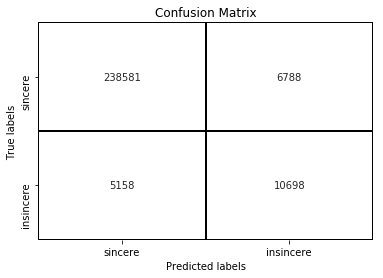

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])

plt.show()

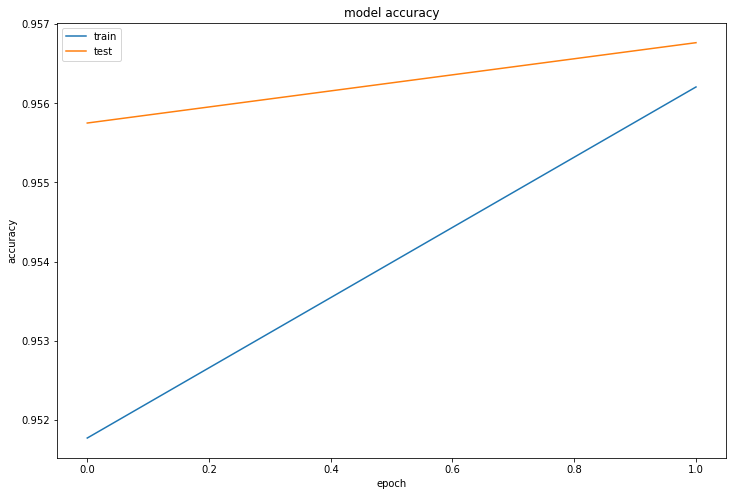

In [36]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

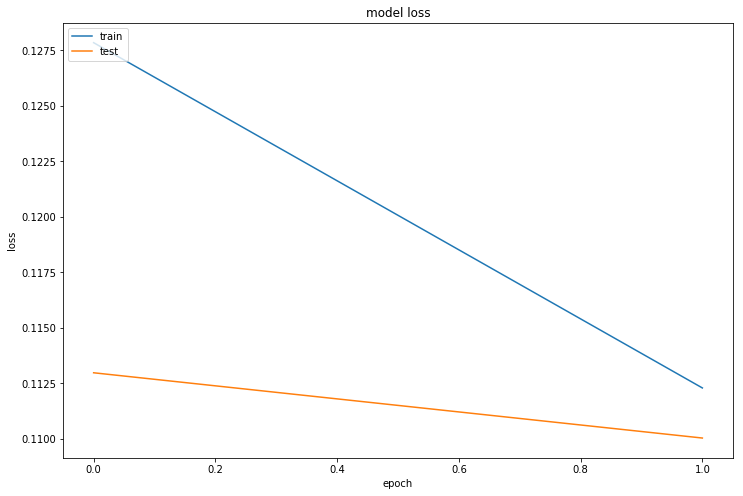

In [37]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

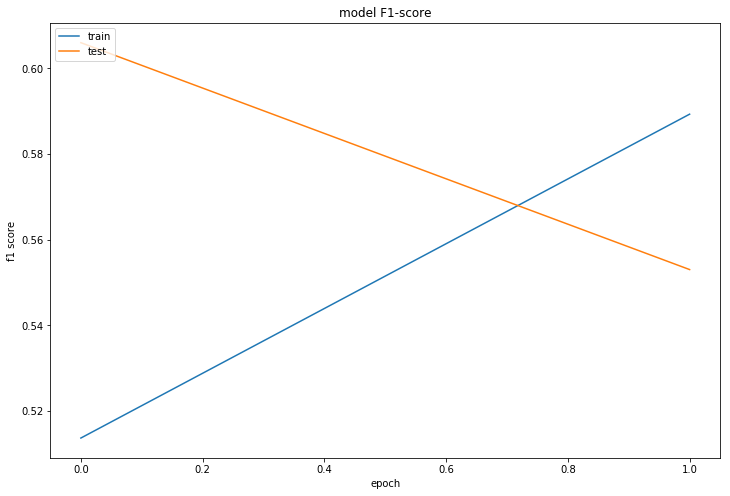

In [38]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [40]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [ ]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

# Analyze predictions

In [ ]:
prediction_df = pd.DataFrame({"qid":test_df["qid"].values})
prediction_df['prediction'] = (pred_test > threshold).astype(int)

In [ ]:
type(hist)

In [ ]:
import pickle


pickle_out = open(MODEL_VERSION + '.hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()